## 0 - Get setup

In [1]:
!pip install --upgrade torchvision
!pip install --upgrade torch
import torch
import torchvision
print(f"torch version:{torch.__version__}")
print(f"torchvision version:{torchvision.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [3]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 37.28 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [4]:
!ls going_modular/going_modular

README.md    data_setup.py  model_builder.py  train.py
__pycache__  engine.py	    predictions.py    utils.py


In [5]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2 - Creating a function to make an EffNetB2 feature extractor

In [6]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transform=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)



  for param in model.parameters():
    param.requires_grad=False
  torch.manual_seed(seed)
  model.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                 nn.Linear(in_features=1408,out_features=num_classes))
  return model,transform


In [7]:
# Creating the model and its transforms
effnetb2_food101,effnetb2_transforms=create_effnetb2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 97.8MB/s]


In [8]:
# taking a look at the model transforms
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
from torchinfo import summary

summary(model=effnetb2_food101,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:

*    This is because with larger datasets and larger models, overfitting becomes more of a problem.
*    Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique.

For a list of state-of-the-art computer vision recipes: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [10]:
# creating custom transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

## 3 - Getting data for FoodVision Big 
Get Food101 dataset - https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

In [11]:
from torchvision import datasets

# setup data directory
from pathlib import Path
data_dir=Path("data")

# get the training data

train_data=datasets.Food101(root=data_dir,
                            split="train",
                            transform=food101_train_transforms,# apply data augmentation to training data
                            download=True)
test_data=datasets.Food101(root=data_dir,
                           split="test",
                           transform=effnetb2_transforms,# don't perform data augmentation on the test data
                           download=True)

100%|██████████| 4996278331/4996278331 [03:18<00:00, 25123488.89it/s]


Extracting data/food-101.tar.gz to data


In [12]:
# Get Food101 class names
food101_class_names =train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 3.1 - Creating a subset of the Food101 dataset for faster experimenting
We want our first few experiments to run as quick as possible.
To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy on the test dataset (see the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

We want to beat this result using modern deep learning techniques and only 20% of the data.

In [13]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size) # defaults to 20% data split
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2


In [14]:
length_1 = int(len(train_data) * 0.2) # defaults to 20% data split
length_2 = len(train_data) - length_1 # remaining length
length_1,length_2

(15150, 60600)

In [15]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)


[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [16]:
len(train_data_food101_20_percent),len(test_data_food101_20_percent)

(15150, 5050)

## 4 - Turning our Food101 datasets into DataLoaders

In [17]:
# checking the number of CPU available
import os
os.cpu_count()

4

In [18]:
import os
import torch

NUM_WORKERS =os.cpu_count() # 4 # this value is very experimental and the best value will differ depeneding on the hardware you're using, search "pytorch num workers setting for more"
BATCH_SIZE= 32

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS,
                                                                  pin_memory=True) #  enables faster data transfer to CUDA-enabled GPUs
# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS,
                                                                 pin_memory=True) #  enables faster data transfer to CUDA-enabled GPUs

In [19]:
len(train_dataloader_food101_20_percent),len(test_dataloader_food101_20_percent)

(474, 158)

## 5 - Training FoodVision Big!!!!
Things for training:
* 5 Epochs
* Optimizer: `torch.optim.Adam(lr=1e-3)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Why use label smoothing?
Label Smoothing helps to prevent overfitting (it's a regularization technique).
Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:

  [0.00, 0.00, 0.99, 0.01, 0.00]

With label smoothing and 5 classes:

  [0.01, 0.01, 0.96, 0.01, 0.01]

>**Note:**Depending on your hardware, running the following cell may take 15-20 minutes (takes about 17 minutes on a NVIDIA Tesla P100 GPU).                                       



In [20]:
from going_modular.going_modular import engine
# Setup optimizer
optimizer=torch.optim.Adam(params=effnetb2_food101.parameters(),
                           lr=1e-3)
# Setup loss
loss_fn=torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6322 | train_acc: 0.2879 | test_loss: 2.7671 | test_acc: 0.4915
Epoch: 2 | train_loss: 2.8623 | train_acc: 0.4394 | test_loss: 2.4654 | test_acc: 0.5377
Epoch: 3 | train_loss: 2.6598 | train_acc: 0.4848 | test_loss: 2.3543 | test_acc: 0.5647
Epoch: 4 | train_loss: 2.5508 | train_acc: 0.5098 | test_loss: 2.3036 | test_acc: 0.5763
Epoch: 5 | train_loss: 2.5006 | train_acc: 0.5240 | test_loss: 2.2805 | test_acc: 0.5791


## 6 - Inspecting loss curves of FoodVision Big model

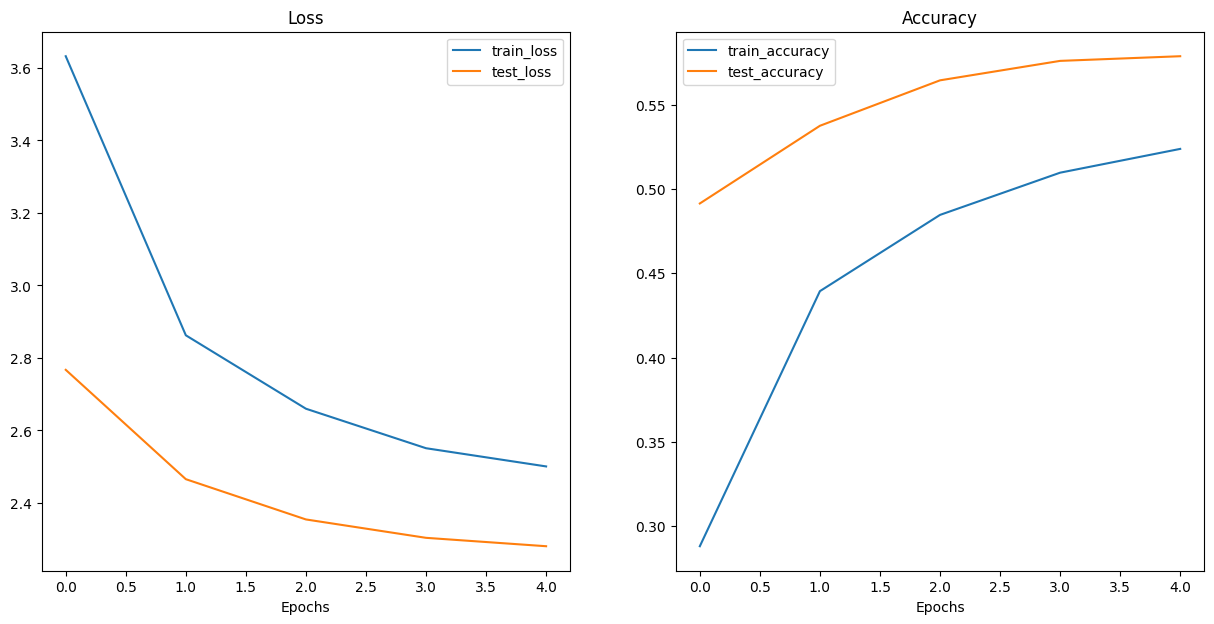

In [21]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_results)

## 7 - Save and load FoodVision Big model

In [23]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path="effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)


[INFO] Saving model to: models/effnetb2_feature_extractor_food101_20_percent.pth


In [24]:
# Create Food101 compatible EffnetB2 instance
loaded_effnetb2_food101 ,effnetb2_transforms=create_effnetb2_model(num_classes=len(food101_class_names))
# load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/effnetb2_feature_extractor_food101_20_percent.pth"))

/tmp/ipykernel_34/1954454252.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/effnetb2_feature_extractor_food10

<All keys matched successfully>

## 8 - Checking FoodVision Big model size

In [25]:
from pathlib import Path

# Get thr model size in bytes then convert to megabyted
pretrained_effnetb2_food101_model_size=Path("models",effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 9 - Turning our FoodVision Big model into a deployable app


Deploying a model allows you to see how your model goes in the real-world (the ultimate test set).

Let's create an outline for our FoodVision Big app:

```
demos/
└── foodvision_big/
    ├── effnetb2_feature_extractor_food101_20_percent.pth
    ├── app.py
    ├── class_names.txt
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [27]:
from pathlib import Path

# Create Foodvision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path/"examples").mkdir(parents=True,exist_ok=True)

In [28]:
!ls demos/foodvision_big/

examples


### 9.1 - Downloading an example image and moving it to the `examples` directory

In [29]:
# Download and move example image
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

--2024-08-06 20:54:53--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg [following]
--2024-08-06 20:54:54--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: '04-pizza-dad.jpeg'

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2024-08-06 20:54:54 (54.6 MB/s) - '04-pizza-dad.jpeg' saved 

In [30]:
!mv models/effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big/

In [33]:
!ls demos/foodvision_big/

effnetb2_feature_extractor_food101_20_percent.pth  examples


### 9.2 - Saving Food101 class names to file (class_names.txt)

Let's save all of the Food101 class names to a .txt file so we can import them and use them in our app.


In [34]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [35]:
# create a path for food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path/"class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [36]:
# Write food101 class names to text file
with open(file=foodvision_big_class_names_path,mode="w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names))#new line per class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [37]:
# checking our class names file
with open(file=foodvision_big_class_names_path, mode="r") as f:
  food101_class_names_loaded=[food.strip() for food in f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 9.3 - Turning our FoodVision Big model into a Python script (`model.py`)


In [38]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.model.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad=False

  torch.manual_seed(seed)
  model.classifier=nn.Sequential(
      nn.Dropout(p=0.3,inplace=True)
      nn.Linear(in_features=1408,out_features=num_classes)
  )
  return model,transforms


Writing demos/foodvision_big/model.py


### 9.4 - Turning our FoodVision Big Gradio app into a Python script (`app.py`)
The app.py file will have four major parts:

 1.   Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather than with a Python list
 2.   Model and transforms preparation - we'll need to make sure our model is suitable for FoodVision Big
 3.  Predict function (`predict()`) - this can stay the same as the original `predict()`
 4.   Gradio app - our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates


In [39]:
%%writefile demos/foodvision_big/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple,Dict

# Setup class names
with open(file="class_names.txt",mode='r') as f:
  class_names=[food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ### 
# Create model and transforms

effnetb2,effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
    map_location=torch.device("cpu")) # load model to CPU
)

### 3. preduct function
def predict(img)->Tuple[Dict,float]:
  # start a timer
  start_time=timer()

  # Transform the input image for use with EffNetB2
  img=effnetb2_transforms(img).unsqueeze(0) # nsqueeze =add the batch dimension

  # put model into eval mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs=torch.softmax(input=effnetb2(img),dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i] for i in range(len(class_names)))}

  # Calculate pred time
  end_time=timer()
  pred_time=round(end_time-start_time,4)

  # return pred dict and pred time
  return pred_labels_and_probs,pred_time

### 4. Gradio app ###
# Create title, description and article
title ="FoodVision BIG"
description="An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images [101 classes of food from the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article="Created at [https://colab.research.google.com/github/MRameezU/PyTorch-for-Deep-Learning-Bootcamp/blob/main/09_PyTorch_model_deployment_video.ipynb]"

# create example list
example_list=[["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch() 

Writing demos/foodvision_big/app.py


### 9.5 - Creating a requirements file for FoodVision Big (`requirements.txt`)



In [40]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


### 9.6 Downloading our FoodVision Big app files

In [41]:
# Change into the foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"
   

  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 45%)
  adding: requirements.txt (deflated 4%)


In [42]:
# looking at our folder content
!ls demos/foodvision_big/

app.py						   examples
class_names.txt					   model.py
effnetb2_feature_extractor_food101_20_percent.pth  requirements.txt


In [43]:
import shutil

# Define source file path and destination directory
source_file = "demos/foodvision_big.zip"
destination_dir = "/kaggle/working/"

# Copy the file to the working directory
shutil.copy(source_file, destination_dir)


'/kaggle/working/foodvision_big.zip'